In [8]:
import os
from os.path import join as oj
import sys, time
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data_pecarn
import data_psrc
import data
import train
import matplotlib.gridspec as grd
from data import feats_numerical, feats_categorical, meta
from sklearn.metrics import precision_recall_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from imodels import RuleListClassifier, RuleFit, SLIM
from sklearn.linear_model import LinearRegression
import cvxpy as cp
from skrules import SkopeRules
import sklearn.metrics
import util
# sns.set(style="black")
# plt.style.use('dark_background')
outcome_def = 'iai_intervention' # output
%matplotlib inline
%load_ext autoreload
%autoreload 2

df_pecarn, df_psrc, common_feats, filtered_feats_pecarn, filtered_feats_psrc = data.load_it_all(dummy=True)
df = df_pecarn[common_feats].append(df_psrc[common_feats])
processed_feats = data.select_final_feats(common_feats)

train_idxs = data.pecarn_train_idxs
test_idxs1 = data.pecarn_test_idxs
test_idxs2 = data.psrc_train_idxs + data.psrc_test_idxs
df = df[df.cv_fold.isin(train_idxs)]
print(len(processed_feats), processed_feats)
X, y = df[processed_feats], df[outcome_def]
X_train, y_train = X[:len(y)//2], y[:len(y)//2]
X_test, y_test = X[len(y)//2:], y[len(y)//2:]

/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.

22 ['AbdDistention_yes', 'AbdTenderDegree_Mild', 'AbdTenderDegree_Moderate', 'AbdTenderDegree_None', 'AbdTenderDegree_Severe', 'AbdTrauma_or_SeatBeltSign_yes', 'AbdomenPain_yes', 'Age', 'CostalTender_yes', 'DecrBreathSound_yes', 'GCSScore_Full_yes', 'Hypotension_yes', 'InitHeartRate', 'InitSysBPRange', 'MOI_Bike collision/fall', 'MOI_Fall from an elevation', 'MOI_Motor vehicle collision', 'MOI_Motorcycle/ATV/Scooter collision', 'MOI_Object struck abdomen', 'MOI_Pedestrian/bicyclist struck by moving vehicle', 'ThoracicTrauma_yes', 'VomitWretch_yes']


# fit simple models

**decision tree**

  0%|          | 0/6 [00:00<?, ?it/s]/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 6/6 [00:00<00:00, 126.71it/s]


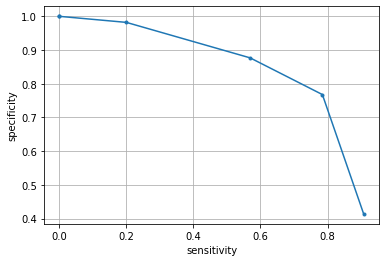

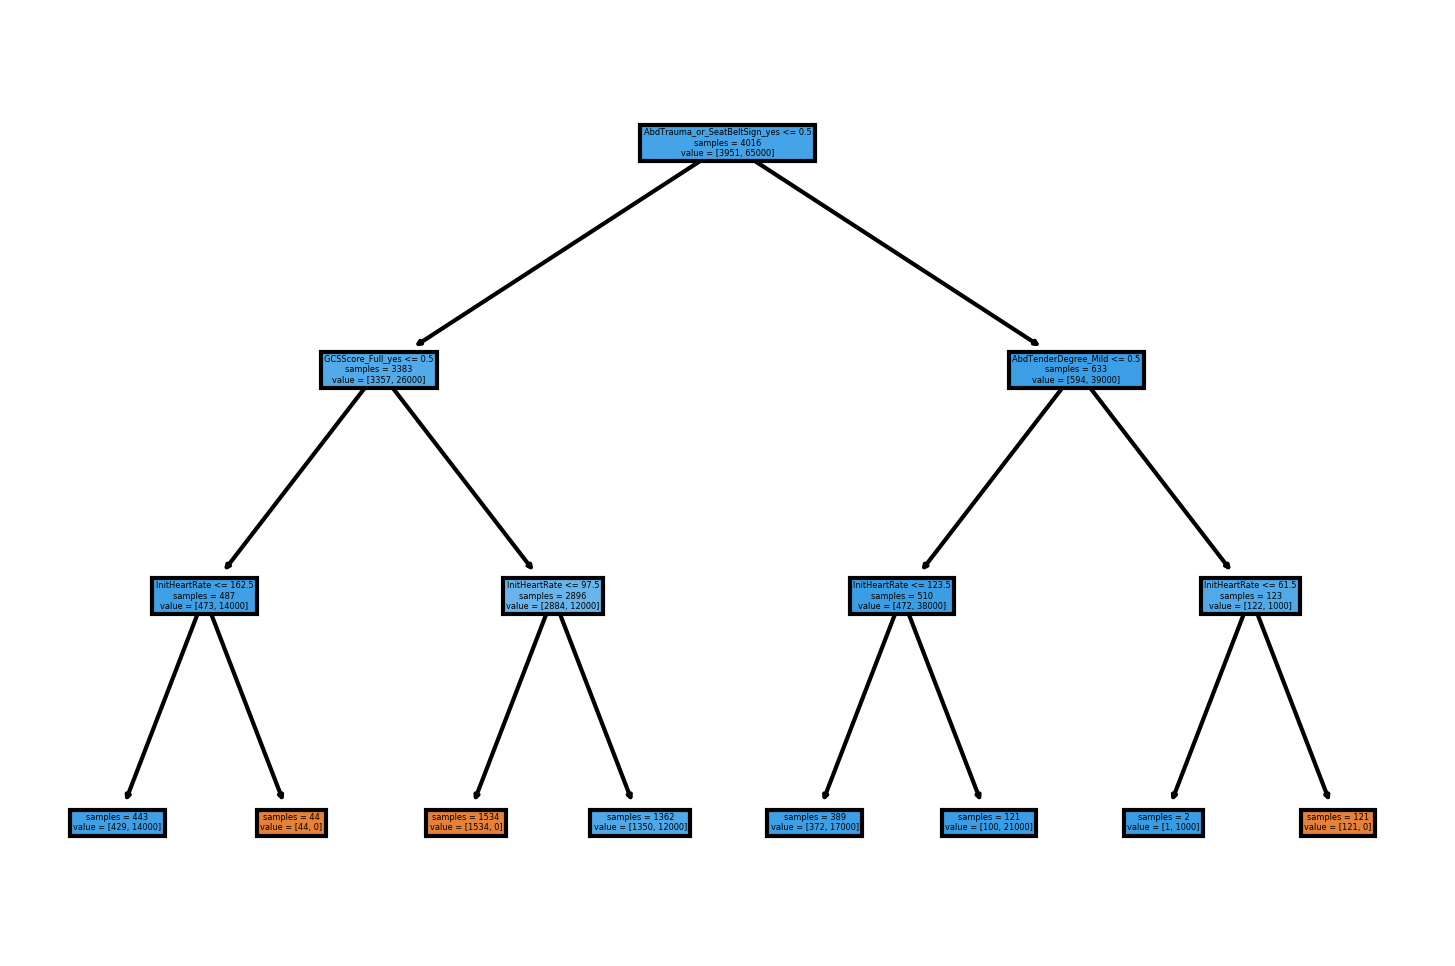

In [16]:
# specify a decision tree with a maximum depth
dt = DecisionTreeClassifier(max_depth=3, class_weight={0:1, 1:1e3})
dt.fit(X_train, y_train)

# calculat mse on the training data
preds = dt.predict(X_test)
preds_proba = dt.predict_proba(X_test)
# print(preds)
sens, spec = util.sensitivity_specificity_curve(y_test, preds_proba[:, 1])

# print(f'test: {np.mean(np.square(preds-y_test)):0.2f}')
# print(sklearn.metrics.classification_report(y_test, preds))
plt.figure(dpi=300)
plot_tree(dt, feature_names=processed_feats, impurity=False, filled=True)
# plt.savefig('tree.pdf')
plt.show()

**bayesian rule lists**

training...


/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RuleListClassifier Accuracy: 0.9838187702265372 Learned interpretable model:
 Trained RuleListClassifier for detecting IwI
IF DecrBreathSound_yes : 0.5_to_inf THEN probability of IwI: 14.9% (8.3%-23.1%)
ELSE IF AbdTrauma_or_SeatBeltSign_yes : -inf_to_0.5 AND InitSysBPRange : 85.5_to_inf THEN probability of IwI: 0.4% (0.2%-0.7%)
ELSE IF AbdDistention_yes : 0.5_to_inf THEN probability of IwI: 40.5% (25.5%-56.5%)
ELSE IF AbdTenderDegree_Severe : 0.5_to_inf THEN probability of IwI: 25.0% (13.9%-38.0%)
ELSE IF GCSScore_Full_yes : -inf_to_0.5 THEN probability of IwI: 11.5% (5.9%-18.5%)
ELSE probability of IwI: 1.2% (0.4%-2.3%)



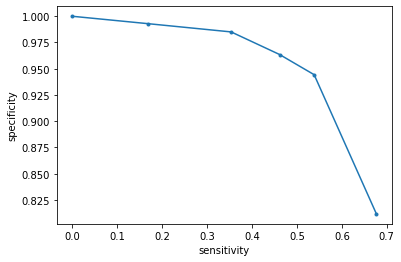

In [4]:
np.random.seed(13)
# train classifier (allow more iterations for better accuracy; use BigDataRuleListClassifier for large datasets)
print('training...')
model = RuleListClassifier(max_iter=10000, class1label="IwI", verbose=False)
model.fit(X_train, y_train, feature_labels=processed_feats)
sens, spec = util.sensitivity_specificity_curve(y_test, model.predict_proba(X_test)[:, 1])
print("RuleListClassifier Accuracy:", model.score(X_test, y_test), "Learned interpretable model:\n", model)

**rulefit**

In [ ]:
# fit a rulefit model
rf = RuleFit()
rf.fit(X_train, y_train, feature_names=processed_feats)

/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


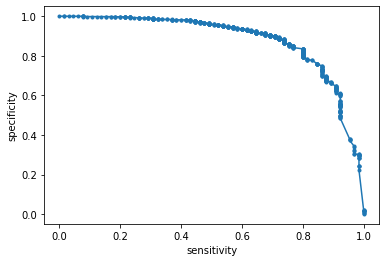

In [6]:
preds = rf.predict(X_test)
# preds_proba = rf.predict_proba(X_test)
# print(preds)
sens, spec = util.sensitivity_specificity_curve(y_test, preds)
# print(sklearn.metrics.classification_report(y_test, preds))

In [ ]:
rules = rf.get_rules()

rules = rules[rules.coef != 0].sort_values("support", ascending=False)

print(rules)

**slim**

In [11]:
# specify a decision tree with a maximum depth
fewest_feats = data.fewest_feats
X_train_small = X_train[fewest_feats]
m = SLIM()
n = 100
m.fit(X_train_small[:n], y_train[:n] * 100, lambda_reg=10)

# calculat mse on the training data
X_test_small = X_test[fewest_feats]
preds = m.predict(X_test_small)
preds_proba = [1 / (1 + np.exp(-y)) for y in preds]
# preds_proba = m.predict_proba(X_test)
print(m.model.coef_.astype(int), m.model.intercept_)

<class 'numpy.ndarray'>
[  6   2  12   0   8  -2 -10   2   0  -5   6  11] 0


 99%|█████████▉| 1209/1219 [00:09<00:00, 146.51it/s]/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 1219/1219 [00:09<00:00, 133.90it/s]


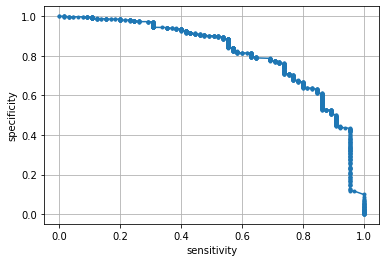

In [33]:
sens, spec = util.sensitivity_specificity_curve(y_test, preds_proba)

**skope rules**

Rules for iai
('InitHeartRate > 108.0 and VomitWretch_yes > 0.5 and AbdTenderDegree_Severe > 0.5', (0.788888888888889, 0.15026010404161666, 2))
('AbdDistention_yes > 0.5 and InitSysBPRange > 70.5 and ThoracicTrauma_yes > 0.5', (0.4177462651727357, 0.15884662956091528, 4))
('AbdDistention_yes > 0.5 and InitSysBPRange <= 107.5 and AbdTenderDegree_Severe > 0.5', (1.0, 0.125, 1))
('AbdDistention_yes > 0.5 and InitHeartRate > 112.5 and AbdTenderDegree_Severe > 0.5', (0.75, 0.125, 1))
('AbdDistention_yes > 0.5 and Hypotension_yes <= 0.5 and AbdTrauma_or_SeatBeltSign_yes > 0.5', (0.3455674760022586, 0.15029352778847388, 4))
('AbdDistention_yes > 0.5 and InitSysBPRange > 65.5 and AbdTrauma_or_SeatBeltSign_yes > 0.5', (0.3138461538461539, 0.15384615384615385, 2))
('AbdDistention_yes > 0.5 and Hypotension_yes > 0.5 and DecrBreathSound_yes <= 0.5', (1.0, 0.11363636363636363, 1))
('InitHeartRate <= 150.5 and InitHeartRate > 137.5 and AbdTenderDegree_Severe > 0.5', (1.0, 0.10638297872340426, 1))
('

/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


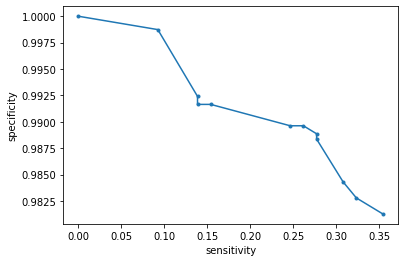

In [2]:
# feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
clf = SkopeRules(max_depth_duplication=3,
                 n_estimators=30,
                 precision_min=0.3,
                 recall_min=0.1,
                 feature_names=processed_feats)
clf.fit(X_train, y_train)
# print the rules
rules = clf.rules_
print("Rules for iai")
for rule in rules:
    print(rule)

# evaluate
y_score = clf.score_top_rules(X_test) # Get a risk score for each test example

sens, spec = util.sensitivity_specificity_curve(y_test, y_score)
plt.show()

In [28]:
def entropy_func(c, n):
    """
    The math formula
    """
    return -(c*1.0/n)*math.log(c*1.0/n, 2)

def entropy_cal(c1, c2):
    """
    Returns entropy of a group of data
    c1: count of one class
    c2: count of another class
    """
    if c1== 0 or c2 == 0:  # when there is only one class in the group, entropy is 0
        return 0
    return entropy_func(c1, c1+c2) + entropy_func(c2, c1+c2)

# get the entropy of one big circle showing above
def entropy_of_one_division(division): 
    """
    Returns entropy of a divided group of data
    Data may have multiple classes
    """
    s = 0
    n = len(division)
    classes = set(division)
    for c in classes:   # for each class, get entropy
        n_c = sum(division==c)
        e = n_c*1.0/n * entropy_cal(sum(division==c), sum(division!=c)) # weighted avg
        s += e
    return s, n

# The whole entropy of two big circles combined
def get_entropy(y_predict, y_real):
    """
    Returns entropy of a split
    y_predict is the split decision, True/Fasle, and y_true can be multi class
    """
    if len(y_predict) != len(y_real):
        print('They have to be the same length')
        return None
    n = len(y_real)
    s_true, n_true = entropy_of_one_division(y_real[y_predict]) # left hand side entropy
    s_false, n_false = entropy_of_one_division(y_real[~y_predict]) # right hand side entropy
    s = n_true*1.0/n * s_true + n_false*1.0/n * s_false # overall entropy, again weighted average
    return s

In [29]:
# from here: https://medium.com/@penggongting/implementing-decision-tree-from-scratch-in-python-c732e7c69aea

class DecisionRuleClassifier(object):
    def __init__(self, max_depth):
        self.depth = 0
        self.max_depth = max_depth
    
    def fit(self, x, y, par_node={}, depth=0):
        if par_node is None: 
            return None
        elif len(y) == 0:
            return None
        elif self.all_same(y):
            return {'val':y[0]}
        elif depth >= self.max_depth:
            return None
        else: 
            col, cutoff, entropy = self.find_best_split_of_all(x, y)    # find one split given an information gain 
            y_left = y[x[:, col] < cutoff]
            y_right = y[x[:, col] >= cutoff]
            par_node = {'col': iris.feature_names[col], 'index_col':col,
                        'cutoff':cutoff,
                       'val': np.round(np.mean(y))}
            par_node['left'] = self.fit(x[x[:, col] < cutoff], y_left, {}, depth+1)
            par_node['right'] = self.fit(x[x[:, col] >= cutoff], y_right, {}, depth+1)
            self.depth += 1 
            self.trees = par_node
            return par_node
    
    def find_best_split_of_all(self, x, y):
        col = None
        min_entropy = 1
        cutoff = None
        for i, c in enumerate(x.T):
            entropy, cur_cutoff = self.find_best_split(c, y)
            if entropy == 0:    # find the first perfect cutoff. Stop Iterating
                return i, cur_cutoff, entropy
            elif entropy <= min_entropy:
                min_entropy = entropy
                col = i
                cutoff = cur_cutoff
        return col, cutoff, min_entropy
    
    def find_best_split(self, col, y):
        min_entropy = 10
        n = len(y)
        for value in set(col):
            y_predict = col < value
            my_entropy = get_entropy(y_predict, y)
            if my_entropy <= min_entropy:
                min_entropy = my_entropy
                cutoff = value
        return min_entropy, cutoff
    
    def all_same(self, items):
        return all(x == items[0] for x in items)
                                           
    def predict(self, x):
        tree = self.trees
        results = np.array([0]*len(x))
        for i, c in enumerate(x):
            results[i] = self._get_prediction(c)
        return results
    
    def _get_prediction(self, row):
        cur_layer = self.trees
        while cur_layer.get('cutoff'):
            if row[cur_layer['index_col']] < cur_layer['cutoff']:
                cur_layer = cur_layer['left']
            else:
                cur_layer = cur_layer['right']
        else:
            return cur_layer.get('val')
        
d = DecisionRuleClassifier(max_depth=5)

In [ ]:
d.fit(X_train, y_train)

In [32]:
from sklearn.datasets import load_iris
from pprint import pprint
import math
iris = load_iris()

x = iris.data
y = iris.target

clf = DecisionRuleClassifier(max_depth=7)
m = clf.fit(x, y)

pprint(m)

{'col': 'petal width (cm)',
 'cutoff': 1.0,
 'index_col': 3,
 'left': {'val': 0},
 'right': {'col': 'petal width (cm)',
           'cutoff': 1.8,
           'index_col': 3,
           'left': {'col': 'petal length (cm)',
                    'cutoff': 5.0,
                    'index_col': 2,
                    'left': {'col': 'petal width (cm)',
                             'cutoff': 1.7,
                             'index_col': 3,
                             'left': {'val': 1},
                             'right': {'val': 2},
                             'val': 1.0},
                    'right': {'col': 'petal width (cm)',
                              'cutoff': 1.6,
                              'index_col': 3,
                              'left': {'val': 2},
                              'right': {'col': 'sepal length (cm)',
                                        'cutoff': 7.2,
                                        'index_col': 0,
                                        'left